In [1]:
import os 
import matplotlib.pyplot as plt
import numpy as np
from scipy.io import wavfile
import librosa, soundfile as sf

In [2]:
ABS_PATH = os.path.dirname(os.path.dirname(os.path.abspath("")))
SRC_PATH = os.path.join(ABS_PATH, "static", "audios", "0_src")
OUT_PATH = os.path.join(ABS_PATH, "static", "audios", "1_noise_reduced")

In [77]:
class AudioWorker():
    
    def __init__(self, audio_path):
        self.audio_path = audio_path
        
        self.sample_rate, self.samples = wavfile.read(audio_path)
        if len(self.samples.shape)==2:
            self.samples = np.array(self.samples[:,0], dtype=float)
        else: self.samples = np.array(self.samples, dtype=float)
        
    def get_mel_specs(self):
        specs = librosa.feature.melspectrogram(y=self.samples, sr=self.sample_rate, n_mels=128,
                                   fmax=14000)
        specs_dB = librosa.power_to_db(specs, ref=np.max)
        return specs_dB
                
        
    
    def segmentation(self, specs, save_fig=False):
        specs_maxs = specs.argmax(axis=0)
        specs_maxs_ma = np.convolve(specs_maxs, np.ones(3), mode="same")
        cut_indices = np.where(specs_maxs_ma>specs_maxs_ma.mean(), 1, 0)
        
        cut_indices = np.convolve(cut_indices, np.ones(10), mode="same")
        cut_indices = np.where(cut_indices==10, 1, 0)
        cut_indices = np.convolve(cut_indices, np.ones(80), mode="same")
        cut_indices = np.where(cut_indices>=1, 1, 0)
        
        # To get on and offsets
        diff = cut_indices[1:] - cut_indices[:-1]
        offsets = np.where(diff==-1)
        onsets = np.where(diff==1)
        
        # Just for plotting
        cut_indices = np.where(cut_indices>=1)
        
        
        fig, ax = plt.subplots(nrows=1, figsize=(16,4), sharex=True)

        times = librosa.times_like(specs, sr=self.sample_rate)
        img = librosa.display.specshow(specs,
                                        x_axis='time', y_axis='mel', ax=ax, sr=self.sample_rate)
        ax.vlines(times[cut_indices], 0, 20000, alpha=0.05, color="y")
        ax.vlines(times[onsets], 0, 20000, color="g", alpha=0.7)
        ax.vlines(times[offsets], 0, 20000, color="r", alpha=0.3)
        if save_fig: plt.savefig(f"{os.path.join(OUT_PATH, os.path.basename(self.audio_path))}-segmentation.png")
        
        intervals = (times[onsets], times[offsets])
        onsets, offsets = list(intervals[0]), list(intervals[1])


        pauses = [onset-offset for onset, offset in zip(onsets, offsets)]
        onsets.insert(0,0)
        singing = [-(onset-offset) for onset, offset in zip(onsets, offsets)]
        
        ax.set_title(f"{os.path.basename(self.audio_path)}     s_mean:{np.array(singing).mean():.1f}s     p_mean: {np.array(pauses).mean():.1f}s")
        
    
    
    def plot_mel_spec(self, specs, save_fig=False):
        
        fig, ax = plt.subplots(nrows=1, figsize=(16,4), sharex=True)
        img = librosa.display.specshow(specs,
                                        x_axis='time', y_axis='mel', ax=ax, sr=self.sample_rate)
        ax.set_title("Mel spectogram")
        times = librosa.times_like(specs, sr=self.sample_rate)

        specs_maxs = specs.argmax(axis=0)
        specs_maxs_ma = np.convolve(specs_maxs, np.ones(10), mode="same")
        ax.vlines(times[np.where(specs_maxs_ma>specs_maxs_ma.mean())], 0, 1000, color="r")
        # ax.vlines(times[np.where(spec_diffs.mean(axis=0)>spec_diffs.mean())], 0, 1000)
        ax.scatter(times, specs_maxs**2, s=1, color="y", alpha=1)

        fig.colorbar(img, ax=ax, format='%+2.0f dB')
        plt.suptitle(os.path.basename(self.audio_path))
        if save_fig: plt.savefig(f"{os.path.join(OUT_PATH, os.path.basename(self.audio_path))}-1.png")
        

C:\Users\moorb\AppData\Local\Temp\ipykernel_3564\1262969578.py:38: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(nrows=1, figsize=(16,4), sharex=True)


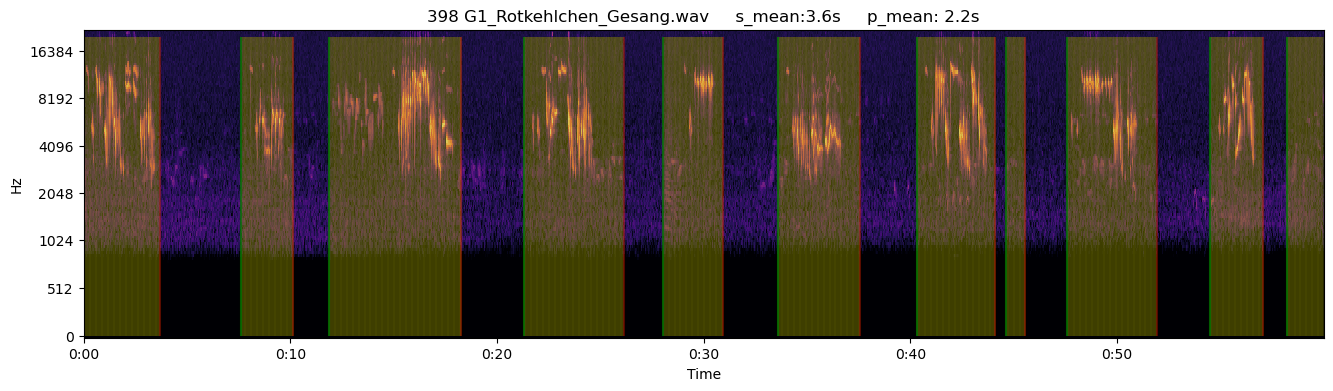

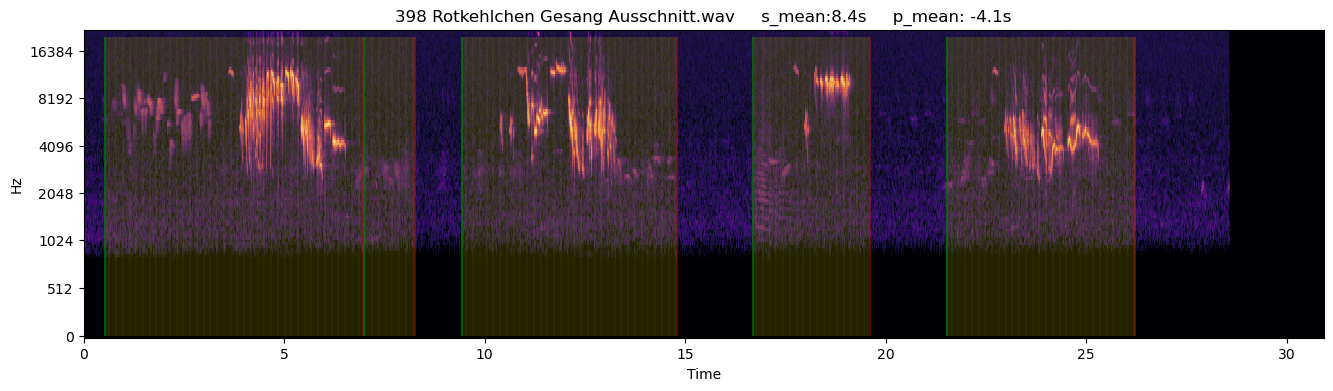

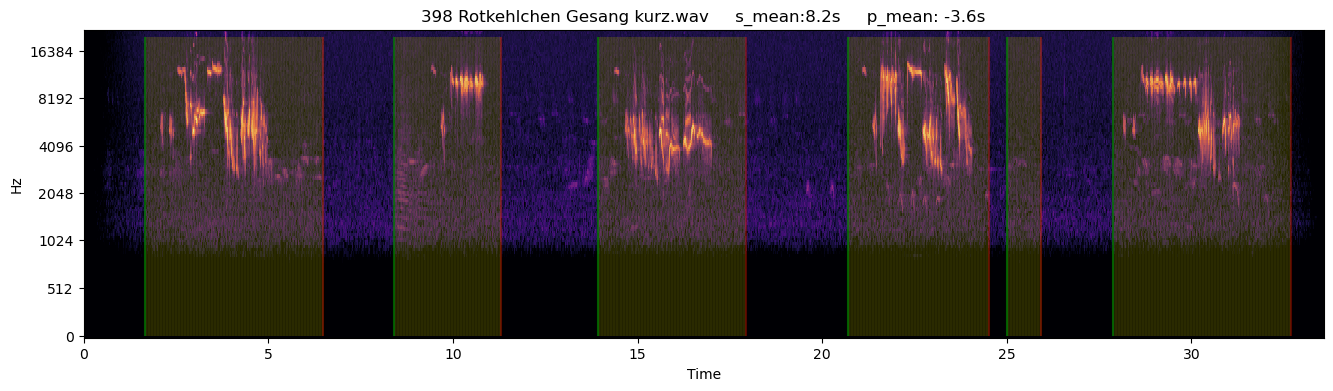

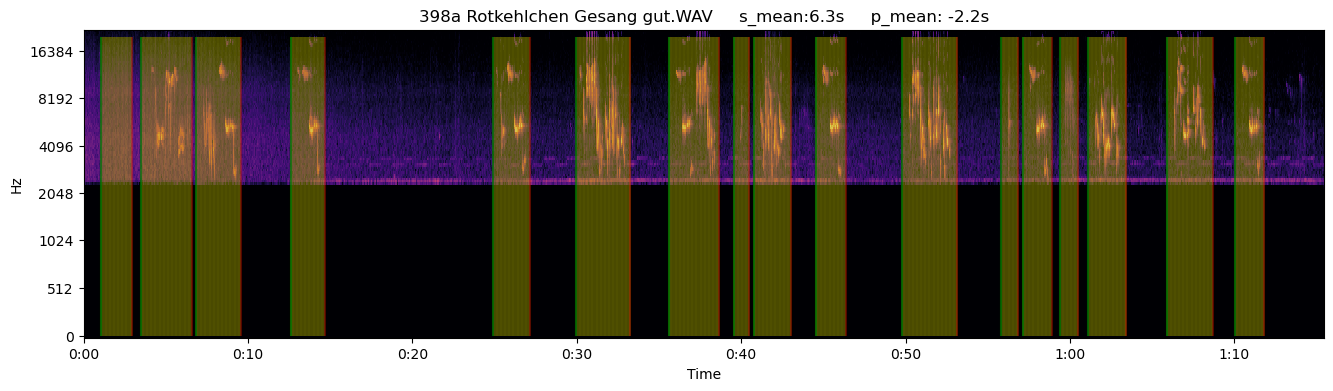

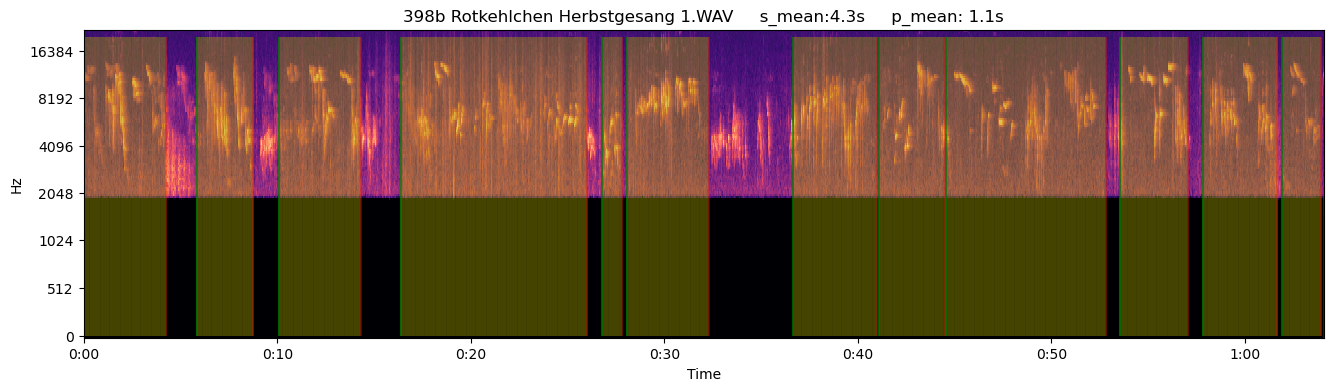

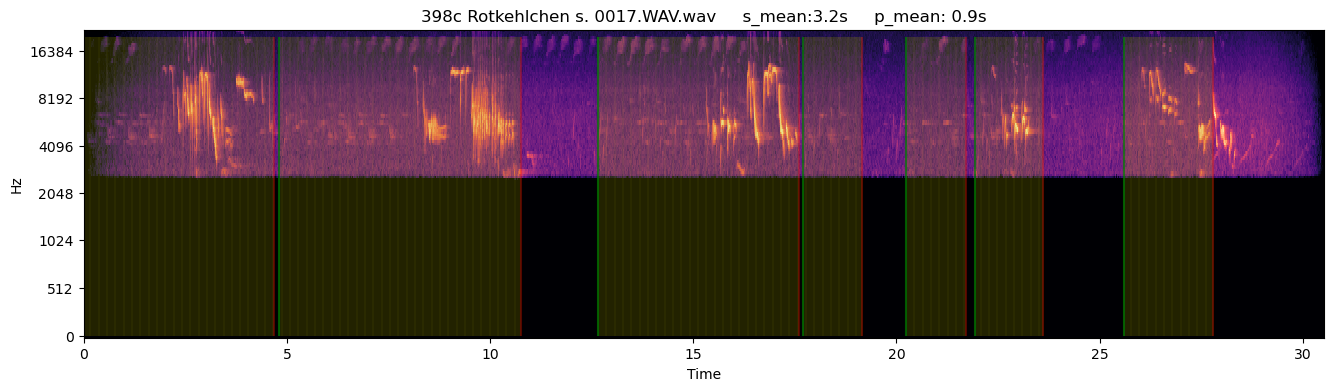

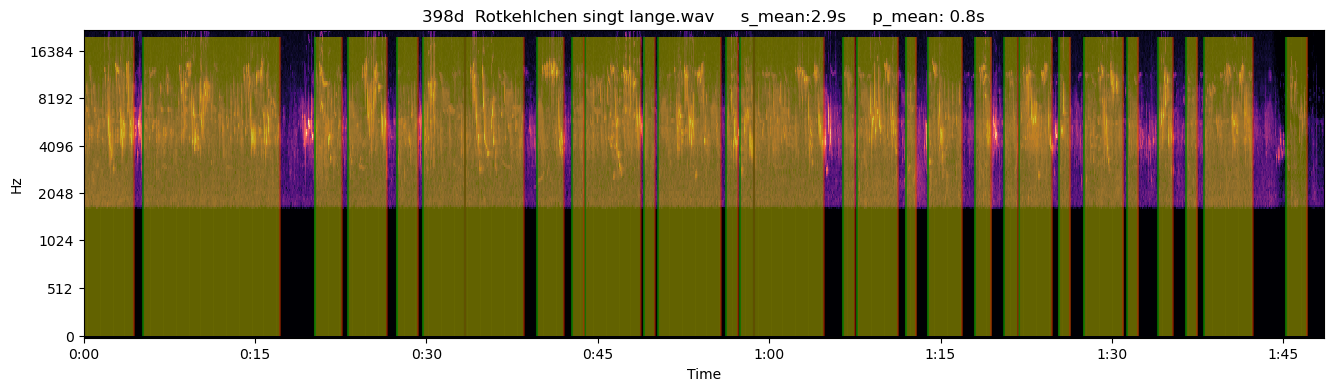

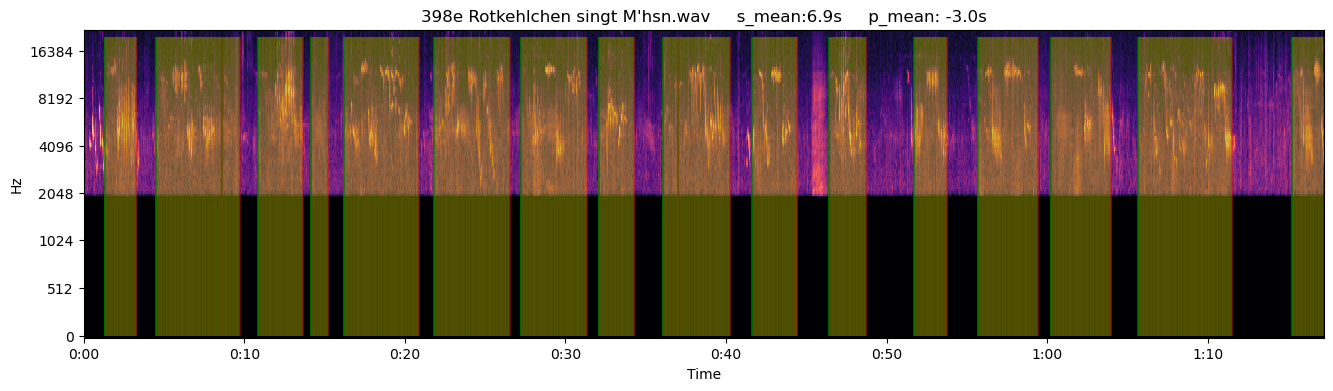

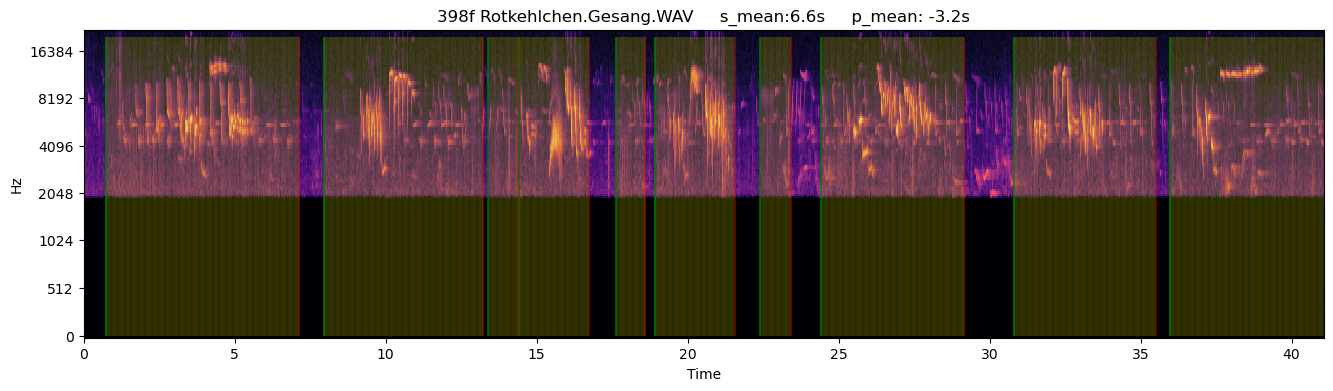

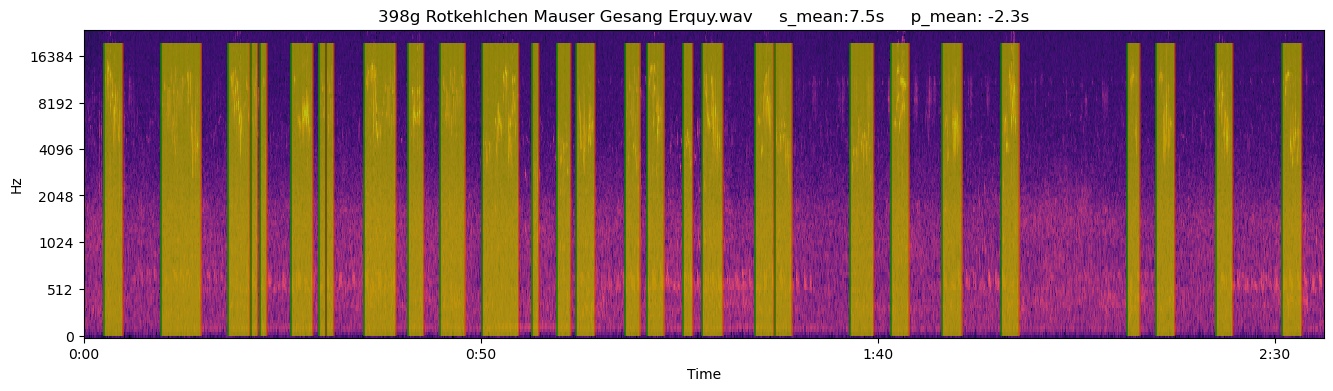

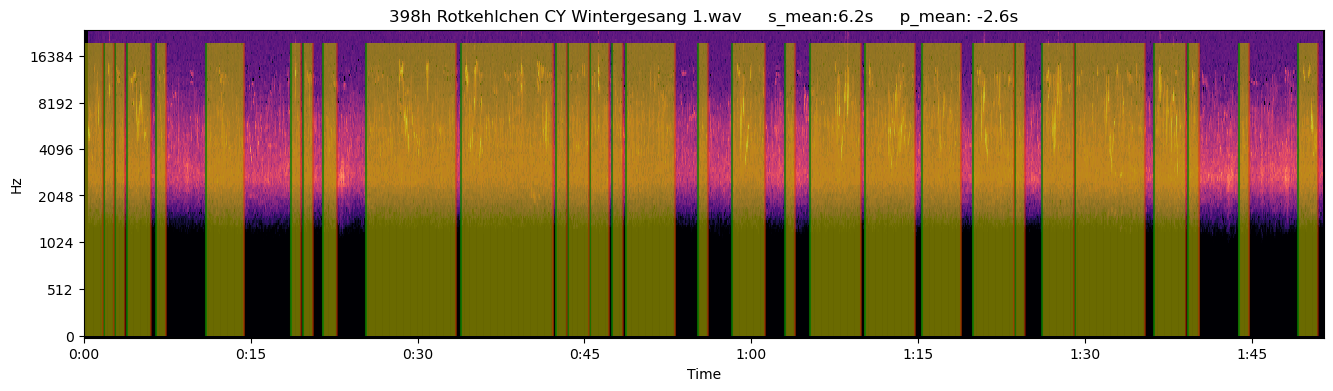

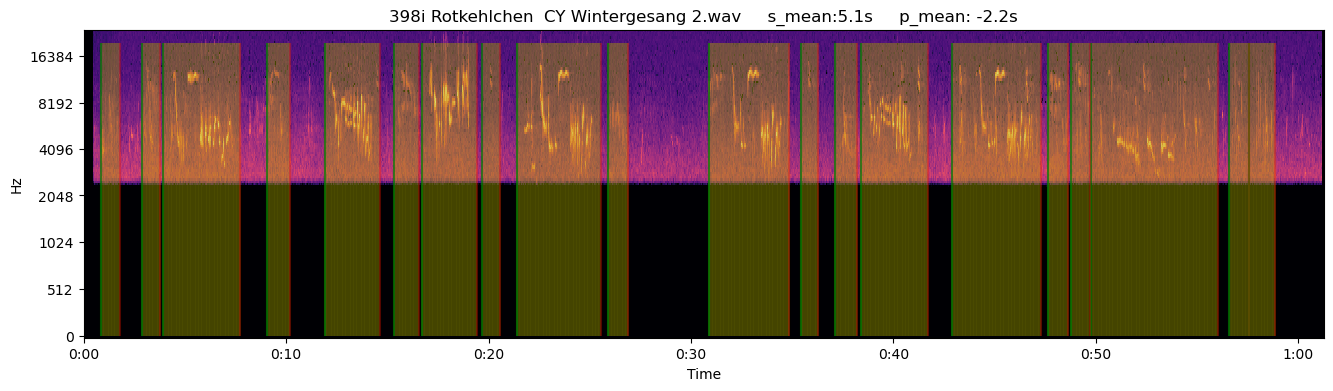

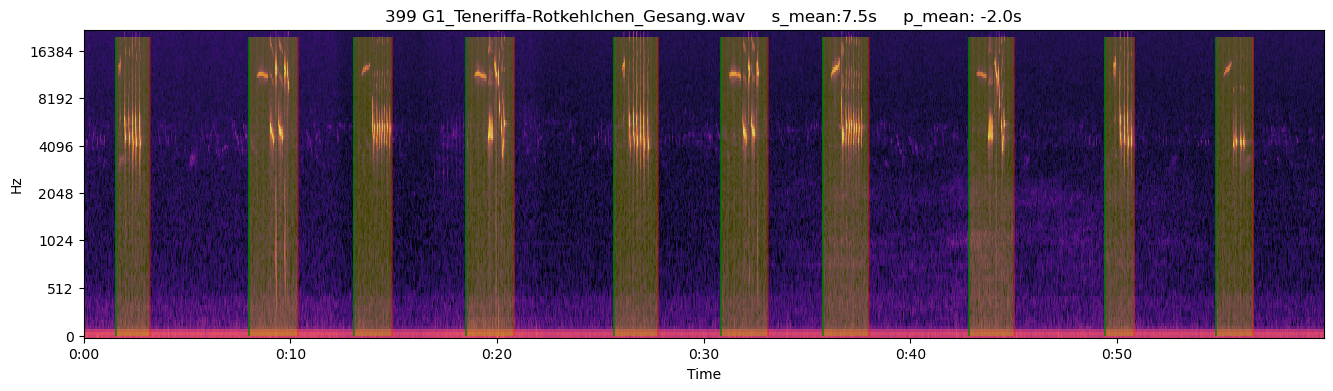

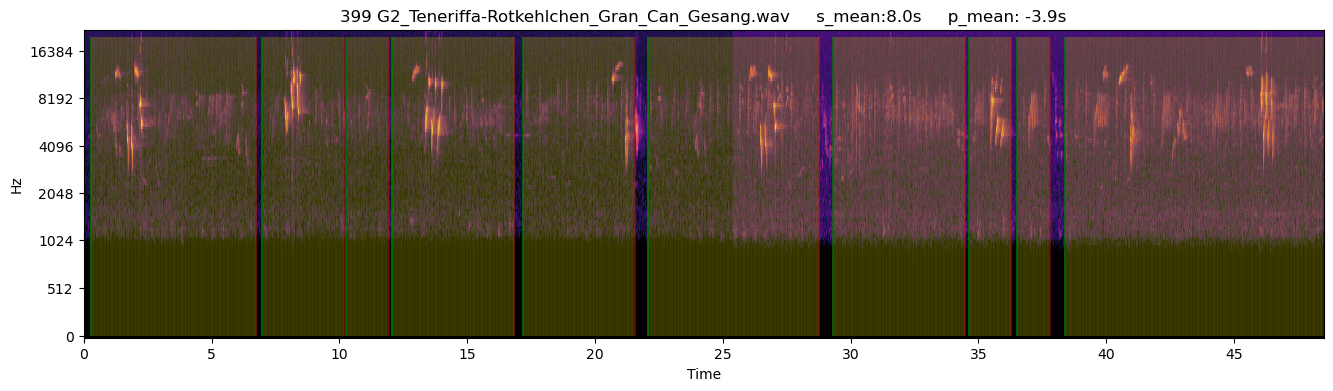

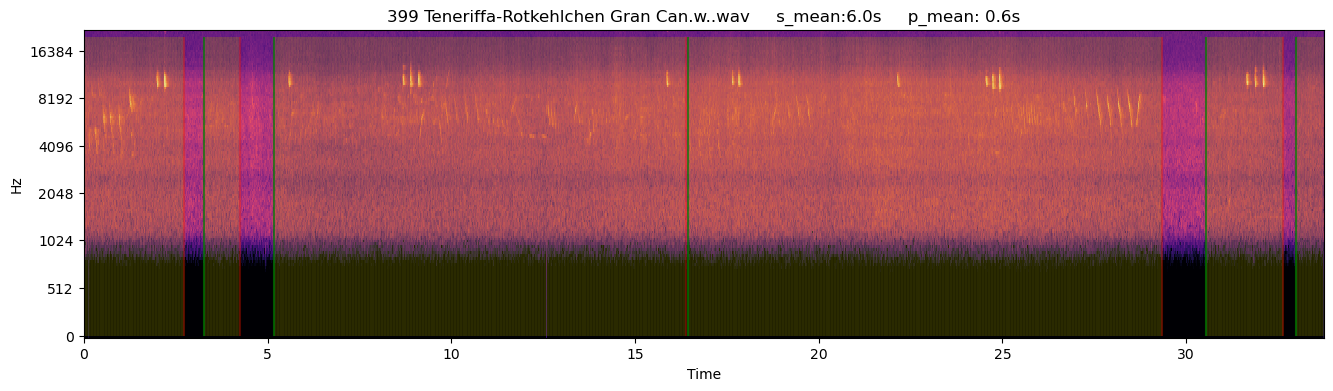

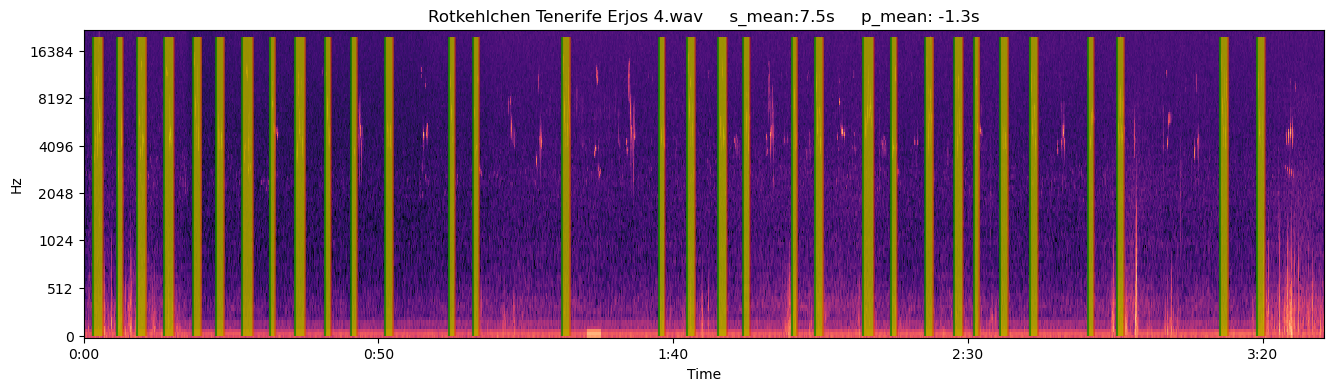

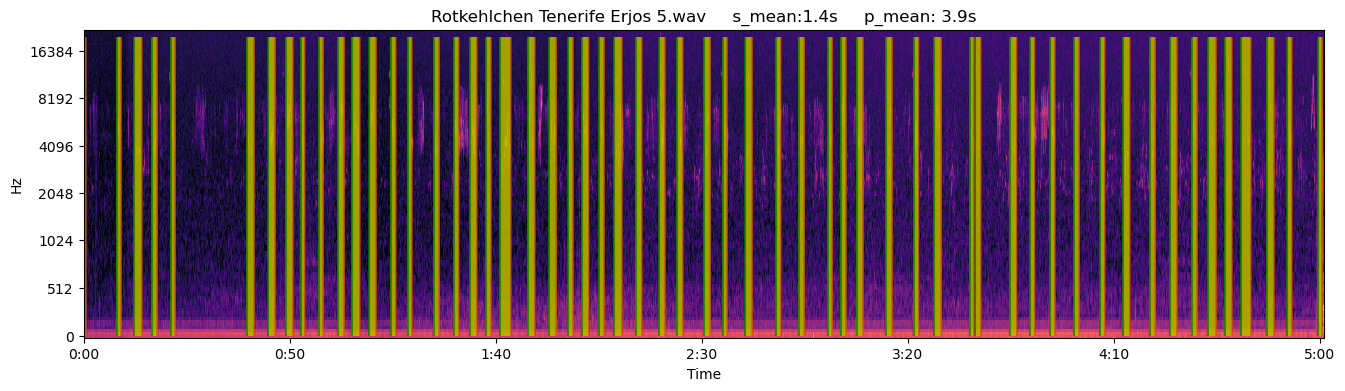

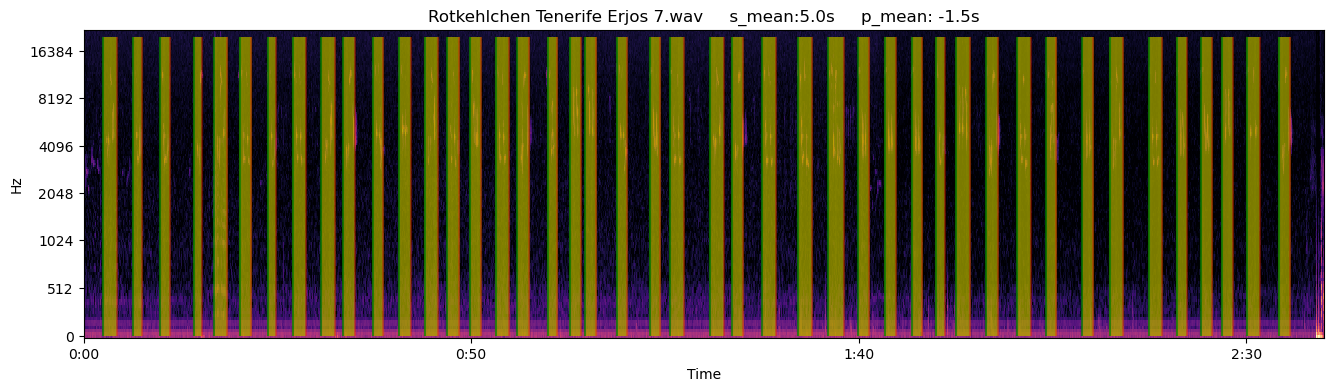

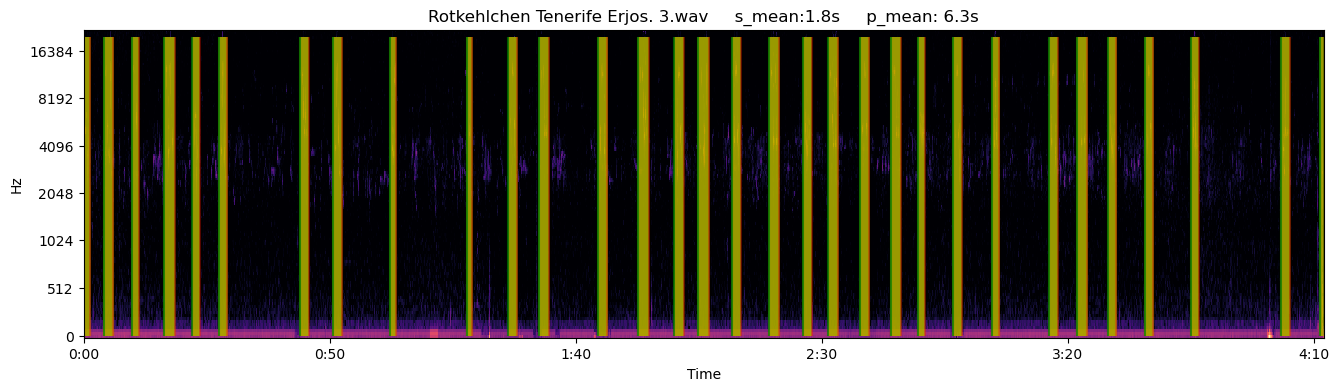

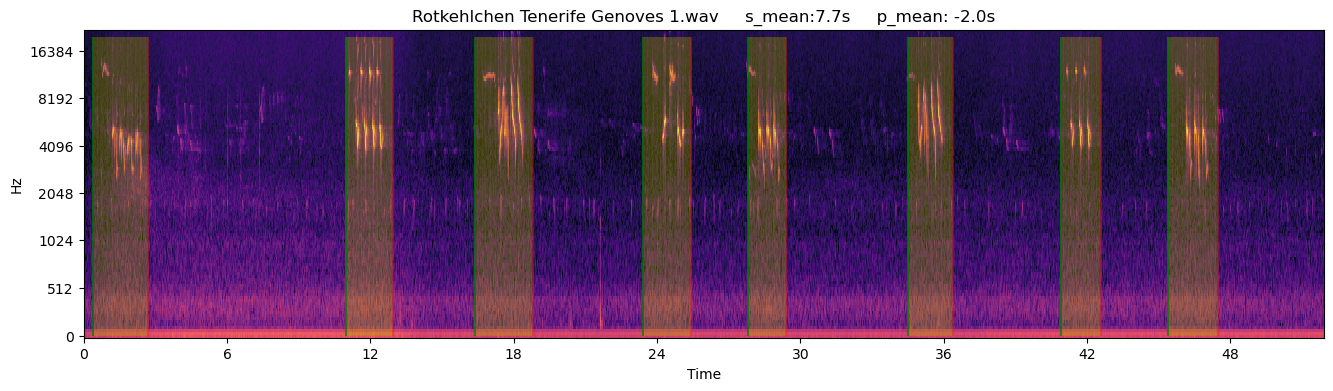

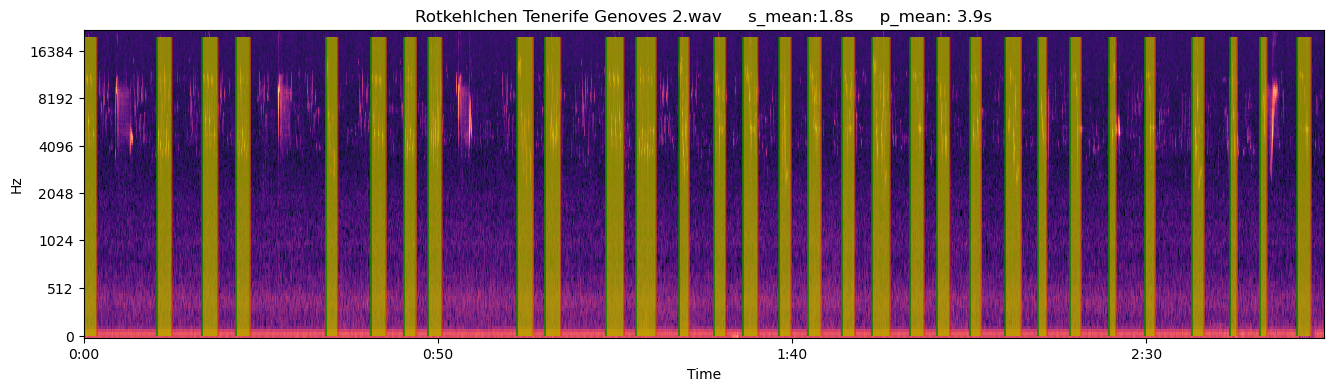

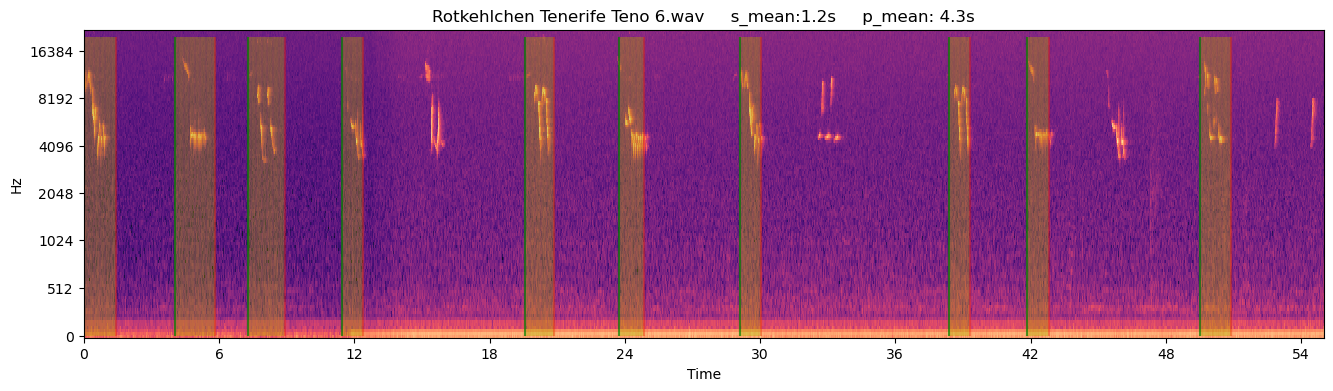

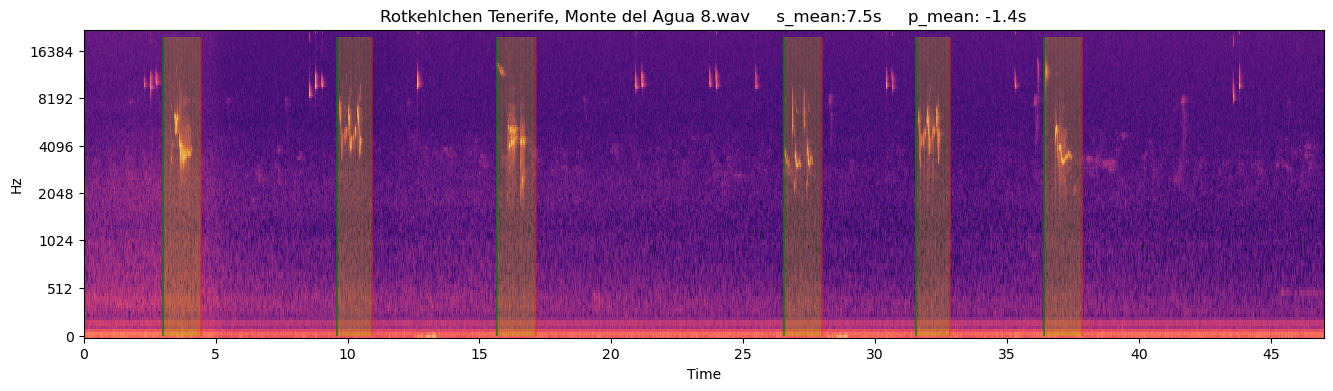

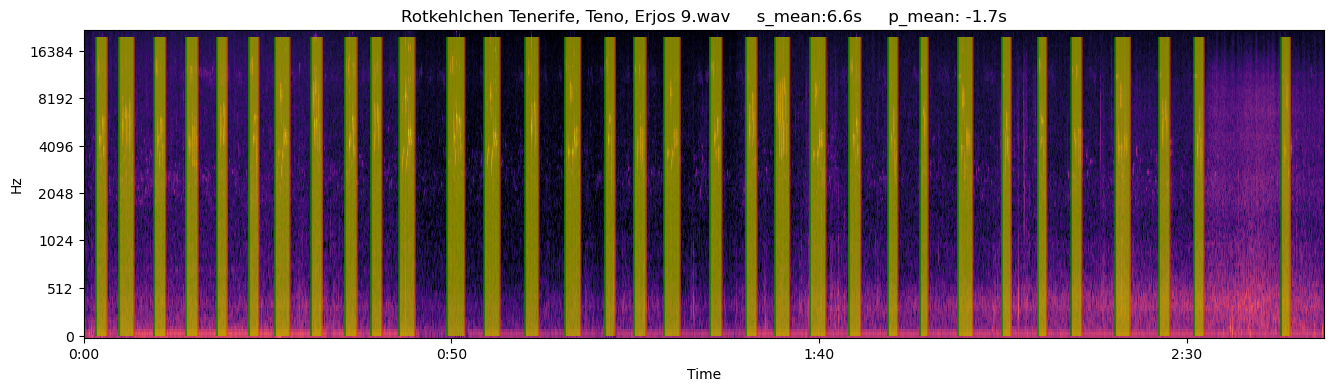

In [79]:
for fname in os.listdir(SRC_PATH)[:]:
    if fname.lower().endswith(".wav"):
        audio_path = os.path.join(SRC_PATH, fname)
        audioWorker = AudioWorker(audio_path=audio_path)
        specs = audioWorker.get_mel_specs()
        # audioWorker.plot_mel_spec(specs, save_fig=False)
        intervals = audioWorker.segmentation(specs, save_fig=True)